Files already downloaded and verified
Files already downloaded and verified


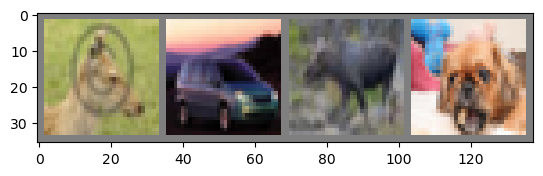

deer  car   deer  dog  
[1,  2000] loss: 2.189
[1,  4000] loss: 1.877
[1,  6000] loss: 1.685
[1,  8000] loss: 1.585
[1, 10000] loss: 1.501
[1, 12000] loss: 1.450
[2,  2000] loss: 1.392
[2,  4000] loss: 1.366
[2,  6000] loss: 1.338


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class AlexNet(nn.Module):
    def __init__(self, in_channels=3, classes=1000):
        super(AlexNet, self).__init__()

        self.c1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.c2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.c3 = nn.Conv2d(192, 384, kernel_size=3, padding=1) 
        self.c4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.c5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1024, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, classes)

        self.norm = nn.LocalResponseNorm(size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.init_weight()
        
    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.maxpool(self.norm(x))
        x = self.relu(self.c2(x))
        x = self.maxpool(self.norm(x))
        x = self.relu(self.c3(x))
        x = self.relu(self.c4(x))
        x = self.maxpool(self.relu(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def init_weight(self):
        bias = [1,3,4,5,6,7]
        for i,layer in enumerate(self.modules()):
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                if i in bias:
                    nn.init.constant_(layer.bias, 1)
                else:
                    nn.init.constant_(layer.bias, 0)
                
                nn.init.normal_(layer.weight, mean=0, std=0.01)

net = AlexNet()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


num_epochs = 10

loss_list = []


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      
        inputs, labels = data
        
       
        optimizer.zero_grad()
        
     
        outputs = net(inputs)
        
       
        loss = criterion(outputs, labels)
        
   
        loss.backward()
        
     
        optimizer.step()
        
     
        running_loss += loss.item()
        if i % 2000 == 1999:    # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')
dataiter = iter(testloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = AlexNet()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')